In [1]:
import os
import sys
from datetime import datetime
import pandas as pd
import numpy as np
import xarray as xr
import pickle
import netCDF4 as nc

sys.path.append('D:\\mehdi\\WaterBalance_new\\')
from qdwb.evapotranspiration.et import *
from qdwb.evapotranspiration.asset import *
from qdwb.evapotranspiration.convert import *


In [2]:
data_path = "D:\\mehdi\\DailyData\\Data\\"

# list of name of files in folder
def list_of_files(data_path):    
    files = os.listdir(data_path)
    return files

all_list_files = list_of_files(data_path)

# PET

In [3]:
para = ["Tmin", "Tmax"]

list_files = {}

for p in para:
    
    tmp = pd.DataFrame(
        {
            "file": [x for x in all_list_files if x.startswith(p)],
            "year": [int(x.split("_")[1][0:4]) for x in all_list_files if x.startswith(p)]
        }
        
    )
    
    tmp.sort_values(by = "year", inplace = True)
    
    list_files[p] = tmp



In [61]:
soil_water_content = xr.open_dataset("D:\\mehdi\\DailyData\\soil_water_content_1979001.nc")


df = soil_water_content.to_dataframe()
df.to_csv("D:\mehdi\sample.csv", index=False) 

In [5]:
# Define the latitude, longitude, and time coordinates
# lat = np.linspace(-90, 90, num=180)  # Example: 180 latitude points from -90 to 90
# lon = np.linspace(-180, 180, num=360)  # Example: 360 longitude points from -180 to 180
# time = pd.date_range(start='2023-01-01', periods=365, freq='D')  # Example: 365 daily time points

# Create the constant data array
constant_value = 42  # Example constant value
data = np.full((len(soil_water_content.time), len(soil_water_content.y), len(soil_water_content.x)), constant_value)

# Create the xarray dataset
ds = xr.Dataset(
    data_vars={"my_variable": (("time", "y", "x"), data)},
    coords={"y": soil_water_content.y, "x": soil_water_content.x, "time": soil_water_content.time},
)


In [39]:
def no_negative(d):
    if d < 0 : 
        t = 0
    else:
        t = d
    return t

In [60]:
wp = xr.open_dataset("D:\mehdi\DailyData\wilting_point_1979001.nc")



In [62]:

fc = xr.open_dataset("D:\mehdi\DailyData\coefficient_field_capacity_1979001.nc")
df = fc.to_dataframe()
df.to_csv("D:\mehdi\sample2.csv", index=False) 

In [44]:
selected_years = [2010, 2011]

for year in selected_years:
    
    if year == selected_years[0]:
        soil_water_content = xr.open_dataset("D:\mehdi\DailyData\soil_water_content_1979001.nc")
        constant_value_for_AE = 60
        AE = xr.Dataset(
            data_vars={"available_evaporable_water": (("time", "y", "x"), np.full((len(soil_water_content.time), len(soil_water_content.y), len(soil_water_content.x)), constant_value_for_AE))},
            coords={"y": soil_water_content.y, "x": soil_water_content.x, "time": soil_water_content.time},
        )
    else:
        year_tmp = year - 1
        pass
    
    wp = xr.open_dataset("D:\mehdi\DailyData\wilting_point_1979001.nc")
    
    fc = xr.open_dataset("D:\mehdi\DailyData\coefficient_field_capacity_1979001.nc")
    
    Tmin = xr.open_dataset(f"{data_path}{list_files['Tmin'][list_files['Tmin']['year'] == year]['file'].values[0]}")
    
    Tmax = xr.open_dataset(f"{data_path}{list_files['Tmax'][list_files['Tmax']['year'] == year]['file'].values[0]}")
    
    lat = np.repeat(Tmin.lat, Tmin.lon.size).values.reshape(Tmin.lat.size, Tmin.lon.size)
    
    lon = np.repeat(Tmin.lon, Tmin.lat.size).values.reshape(Tmin.lat.size, Tmin.lon.size)
    
    Ra = Tmin.copy(deep = True)
    
    Ra = Ra.rename({'air_temperature': 'extraterrestrial_radiation'})
    
    ET = Tmin.copy(deep = True)
    
    ET = ET.rename({'air_temperature': 'et_hargreaves_samani'})
    
    TE = Tmin.copy(deep = True)
    
    TE = TE.rename({'air_temperature': 'total_evaporable_water'})
    
    MRF = Tmin.copy(deep = True)
    
    MRF = MRF.rename({'air_temperature': 'moisture_reduction_function'})
    
    f_adjusted = Tmin.copy(deep = True)
    
    f_adjusted = f_adjusted.rename({'air_temperature': 'moisture_reduction_function'})
    
    ET_actual = Tmin.copy(deep = True)
    
    ET_actual = ET_actual.rename({'air_temperature': 'actual_evapotranspiration'})
    
    for j_day in range(1, Tmin.time.size + 1):
        
        if j_day != 1:
            pass
        
        print(year, j_day)
        
        Tmin_day = Tmin.to_array()[0, j_day - 1, :, :]
        
        Tmax_day = Tmax.to_array()[0, j_day - 1, :, :]
        
        Tmean_day = (Tmin_day + Tmax_day) / 2
        
        ra_day = np.vectorize(extraterrestrial_radiation)(
            inverse_relative_distance_earth_sun(
                julian_date = j_day
            ),
            sunset_hour_angle(
                latitude=convert_degrees2radians(lat),
                solar_declination = solar_declination(
                    julian_date = j_day
                )
            ),
            convert_degrees2radians(
                degrees = lat
            ),
            solar_declination(
                julian_date = j_day
            )            
        )
        
        Ra["extraterrestrial_radiation"][j_day - 1, :, :] = ra_day
                
        et_day_hargreaves_samani = np.vectorize(ReferenceEvapotranspiration.hargreaves_samani)(
            tmin = Tmin_day,
            tmax = Tmax_day,
            tmean = Tmean_day,
            ra = ra_day
        )
        
        ET["et_hargreaves_samani"][j_day - 1, :, :] = et_day_hargreaves_samani
        
        total_evaporable_water_day = np.vectorize(available_water)(
            permanent_wilting_point_wet = wp["b0"].sel(time = "1979-01-01")[:, :],
            field_capacity_wet = fc["b0"].sel(time = "1979-01-01")[:, :],
            soil_depth = 1000
        )
        
        TE["total_evaporable_water"][j_day - 1, :, :] = total_evaporable_water_day
        
        f_day = np.vectorize(moisture_reduction_function)(
            soil_wetness_in_previous_step = soil_water_content["volumetric_soil_water_layer_1"].sel(time = "1979-01-01")[:, :],
            permanent_wilting_point_wet = wp["b0"].sel(time = "1979-01-01")[:, :],
            field_capacity_wet = fc["b0"].sel(time = "1979-01-01")[:, :],
            soil_depth = 1000
        )
        MRF["moisture_reduction_function"][j_day - 1, :, :] = f_day
        
        f_adjusted_day = np.vectorize(no_negative)(
            d = f_day
        )
        
        f_adjusted["moisture_reduction_function"][j_day - 1, :, :] = f_adjusted_day
        
        et_actual_day = np.vectorize(ActualEvapotranspiration.et_covered)(
            moisture_reduction_function = f_adjusted_day,
            crop_coefficient = 0.5,
            crop_cover = 0.4,
            reference_crop_evapotranspiration = et_day_hargreaves_samani
        )
        ET_actual["actual_evapotranspiration"][j_day - 1, :, :] = et_actual_day
        
        
        
    
        # break
    # Ra.to_netcdf(f"{data_path}Ra_{year}.nc")
    
    # ET.to_netcdf(f"{data_path}ET_{year}.nc")
        
    
    break


2010 1


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 2


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 3


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 4


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 5


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 6


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 7


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 8


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 9


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 10


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 11


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 12


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 13


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 14


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 15


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 16


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 17


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 18


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 19


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 20


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 21


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 22


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 23


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 24


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 25


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 26


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 27


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 28


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 29


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 30


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 31


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 32


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 33


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 34


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 35


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 36


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 37


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 38


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 39


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 40


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 41


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 42


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 43


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 44


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 45


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 46


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 47


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 48


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 49


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 50


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 51


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 52


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 53


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 54


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 55


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 56


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 57


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 58


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 59


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 60


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 61


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 62


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 63


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 64


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 65


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 66


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 67


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 68


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 69


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 70


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 71


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 72


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 73


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 74


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 75


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 76


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 77


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 78


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 79


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 80


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 81


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 82


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 83


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 84


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 85


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 86


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 87


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 88


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 89


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 90


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 91


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 92


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 93


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 94


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 95


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 96


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 97


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 98


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 99


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 100


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 101


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 102


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 103


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 104


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 105


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 106


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 107


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 108


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 109


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 110


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 111


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 112


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 113


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 114


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 115


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 116


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 117


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 118


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 119


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 120


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 121


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 122


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 123


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 124


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 125


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 126


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 127


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 128


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 129


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 130


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 131


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 132


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 133


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 134


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 135


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 136


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 137


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 138


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 139


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 140


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 141


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 142


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 143


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 144


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 145


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 146


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 147


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 148


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 149


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 150


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 151


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 152


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 153


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 154


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 155


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 156


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 157


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 158


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 159


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 160


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 161


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 162


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 163


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 164


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 165


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 166


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 167


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 168


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 169


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 170


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 171


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 172


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 173


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 174


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 175


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 176


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 177


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 178


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 179


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 180


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 181


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 182


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 183


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 184


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 185


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 186


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 187


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 188


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 189


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 190


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 191


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 192


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 193


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 194


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 195


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 196


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 197


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 198


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 199


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 200


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 201


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 202


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 203


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 204


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 205


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 206


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 207


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 208


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 209


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 210


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 211


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 212


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 213


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 214


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 215


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 216


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 217


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 218


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 219


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 220


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 221


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 222


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 223


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 224


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 225


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 226


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 227


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 228


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 229


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 230


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 231


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 232


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 233


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 234


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 235


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 236


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 237


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 238


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 239


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 240


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 241


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 242


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 243


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 244


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 245


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 246


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 247


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 248


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 249


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 250


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 251


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 252


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 253


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 254


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 255


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 256


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 257


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 258


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 259


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 260


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 261


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 262


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 263


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 264


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 265


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 266


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 267


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 268


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 269


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 270


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 271


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 272


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 273


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 274


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 275


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 276


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 277


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 278


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 279


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 280


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 281


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 282


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 283


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 284


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 285


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 286


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 287


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 288


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 289


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 290


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 291


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 292


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 293


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 294


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 295


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 296


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 297


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 298


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 299


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 300


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 301


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 302


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 303


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 304


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 305


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 306


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 307


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 308


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 309


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 310


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 311


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 312


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 313


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 314


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 315


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 316


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 317


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 318


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 319


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 320


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 321


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 322


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 323


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 324


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 325


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 326


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 327


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 328


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 329


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 330


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 331


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 332


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 333


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 334


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 335


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 336


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 337


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 338


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 339


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 340


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 341


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 342


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 343


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 344


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 345


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 346


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 347


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 348


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 349


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 350


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 351


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 352


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 353


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 354


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 355


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 356


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 357


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 358


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 359


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 360


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 361


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 362


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 363


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 364


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


2010 365


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


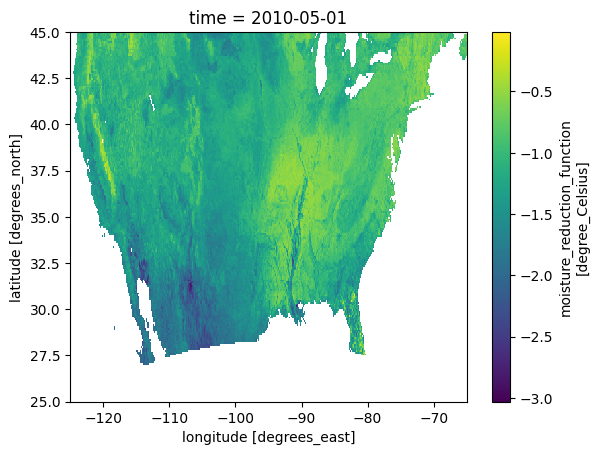

In [50]:
MRF["moisture_reduction_function"].sel(time = "2010-05-01").plot()

In [43]:


aaaa = pd.DataFrame(f_day)
aaaa

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.678652,-0.820645,-0.781933,-0.717970
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.745464,-0.804137,-0.748604,-0.727758,-0.663670
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.734535,-0.684287,-0.660929,-0.785581,-0.699459,-0.890065
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.750268,-0.800541,-0.775134,-0.805211,-0.909908,-0.912408,-0.745418,-0.594765,-0.609121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
Tmin["air_temperature"].sel(time = "2010-01-01")[:, :]

<xarray.DataArray 'air_temperature' (lat: 200, lon: 600)>
array([[10.375 , 10.3125, 10.3125, ..., -5.4375, -5.375 , -6.6875],
       [10.25  , 10.25  , 10.25  , ..., -7.9375, -8.0625, -9.25  ],
       [10.3125, 10.3125, 10.3125, ..., -8.375 , -8.4375, -9.4375],
       ...,
       [17.8125, 17.75  , 17.75  , ..., 22.    , 22.    , 21.875 ],
       [17.875 , 17.75  , 17.75  , ..., 22.    , 22.    , 21.875 ],
       [18.    , 17.8125, 17.8125, ..., 22.1875, 22.1875, 22.0625]],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 -124.9 -124.8 -124.8 -124.6 ... -65.25 -65.15 -65.05
  * lat      (lat) float32 44.95 44.85 44.75 44.65 ... 25.35 25.25 25.15 25.05
    time     datetime64[ns] 2010-01-01
Attributes:
    units:    degree_Celsius

In [22]:
ET.to_netcdf(f"{data_path}ET_{year}.nc")

In [ ]:
Ra = Ra.rename({'air_temperature': 'temp'})

In [ ]:
Ra

In [ ]:
xr.DataArray(
            Tmin.air_temperature,
            coords={
                "time" : Tmin.time.values,
                "lat" : Tmin_day.lat.values,
                "lon" : Tmin_day.lon.values,
            }, 
            dims=['time', 'lat', 'lon']
        )

In [ ]:
Tmin

In [ ]:
with open('D:\\mehdi\\DailyData\\Tmax\\Tmax-30.pkl', 'rb') as f:
    t_max11 = pickle.load(f)

with open('D:\\mehdi\\DailyData\\Tmax\\Tmax-31.pkl', 'rb') as f:
    t_max12 = pickle.load(f)


concatenated_data = xr.concat([t_max11, t_max12], dim='time')
sliced_dataset = concatenated_data.sel(time=slice("2010-01-01", "2010-12-31"))



reshaped_data = result_ET_array.reshape(365,200, 600)

ds_array = sliced_dataset.assign(ET=(['time', 'lat', 'lon'], reshaped_data))

ds_array

In [ ]:
Tmin_day

In [ ]:
# result_array.size
# ET_ca_array = result_array.reshape(365,200,600)
t = Tmin.assign(ra=(['time', 'lat', 'lon'], result_array))
t

In [ ]:
yy = xr.open_dataset("D:\\mehdi\\DailyData\\Data\\Tmax_2010.nc")
yy.sel(time = "2010-01-01")

In [ ]:
def check_between(
    a: float,
    min: float,
    max: float,
    name: str,
):
    if a < min or a > max:
        raise ValueError(f"{name} must be between {min} and {max}!")

In [ ]:
Tmean_day

In [ ]:
for year in list_of_year[:2]:
    t_min_{year} = xr.open_dataset(f"Data\\Tmin_{1979}.nc")
    t_max_{year} = xr.open_dataset(f"Data\\Tmax_{1979}.nc")
    
    for i in range(t_min.sizes["time"]):
        print(i)

In [ ]:
import os
import sys

sys.path.append('D:\\mehdi\\WaterBalance_new\\')

from qdwb.evapotranspiration.et import *
from qdwb.evapotranspiration.asset import *
from qdwb.evapotranspiration.convert import *

In [ ]:
time_list = a['time'].values.astype(str).tolist()

In [ ]:
array_t_min = a.air_temperature.to_numpy()
array_t_min

In [ ]:
vectorized_func = np.vectorize(standard_date_to_Julian_day)
result = vectorized_func(array_t_min)
result